In [22]:
# ARIMA MODEL
# Fit an ARIMA model.

# There are three hyperparameters we need to get values for when fitting an ARIMA model.
# Determine a value of  using the Augmented Dickey-Fuller test.

# Then, determine values of  and  through GridSearching.

# An  model is specified by:
# -how many differences  we need to calculate in order to achieve stationarity.
# -how many lags  we regress  on.
# -how many errors  we regress  on.


# Depending on our values of , , and , we might refer to these models by slightly different names.
# If  and , an AR(p) model is specified by how many lags  we regress  on.
# If  and , an MA(q) model is specified by how many errors  we regress  on.
# If , an ARMA(p, q) model is specified by how many lags  and how many errors  we regress  on.

In [23]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.pipeline import Pipeline
import pymssql
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import plotly.express as px

In [24]:

database = "arctic_analysts_capstone"
user = "arctic_analysts"
password  = "ThisPassw0rd!"
server = "gen10-data-fundamentals-22-02-sql-server.database.windows.net"

def sql_query(query):
    conn = pymssql.connect(server, user, password, database)
    cursor = conn.cursor()
    queried_data = pd.read_sql(query, conn)
    return queried_data

In [25]:
def run_queries():
    tables = ["year", "month", "county", "median_income", "main_table"]

    query = f"SELECT * FROM {tables[0]}"
    year_df = sql_query(query)

    query = f"SELECT * FROM {tables[1]}"
    month_df = sql_query(query)

    query = f"SELECT * FROM {tables[2]}"
    county_df = sql_query(query)

    query = f"SELECT * FROM {tables[3]}"
    median_income_df = sql_query(query)

    query = f"SELECT * FROM {tables[4]}"
    main_table = sql_query(query)

    all_df = [year_df, month_df, county_df, median_income_df, main_table]
    return all_df

In [26]:
def join_tables(all_df):
    year_df = all_df[0]
    month_df = all_df[1]
    county_df = all_df[2]
    median_income_df = all_df[3]
    main_table = all_df[4]

    master_table = pd.merge(
        main_table, year_df, left_on="YearID", right_on="YearID", how="outer"
    )
    print(master_table.shape[0])
    # Now has 5607 rows

    master_table = pd.merge(
        master_table, month_df, left_on="MonthID", right_on="MonthID", how="outer"
    )
    # Now has 5607 rows
    print(master_table.shape[0])

    master_table = pd.merge(
        master_table, county_df, left_on="FIPS", right_on="FIPS", how="outer"
    )
    # Now has 5607 rows
    print(master_table.shape[0])

    master_table = pd.merge(
        master_table,
        median_income_df,
        left_on=["FIPS", "YearID"],
        right_on=["FIPS", "YearID"],
        how="outer",
    )
    # Now has 20727 rows
    print(master_table.shape[0])

    master_table.loc[(master_table.MedianIncome < 0), "MedianIncome"] = None
    return master_table

In [27]:
all_df = run_queries()
master_table = join_tables(all_df)

5607
5607
5607
20727


In [28]:
df = master_table.copy()

In [29]:
df

,FIPS,YearID,MonthID,NewUnits,NewBuildings,MedianHousePrice,AverageRate,AveragePoints,Year,Month,County,AgeGroup,MedianIncome
0,34001,1,1,66,66,136880.0,8.21,1.0,2000,Jan,Atlantic County,NaN,NaN
1,34001,1,2,110,110,137379.0,8.33,1.0,2000,Feb,Atlantic County,NaN,NaN
2,34001,1,3,98,87,137794.0,8.24,1.0,2000,Mar,Atlantic County,NaN,NaN
3,34001,1,4,90,90,138680.0,8.15,1.0,2000,Apr,Atlantic County,NaN,NaN
4,34001,1,5,121,121,139644.0,8.52,1.0,2000,May,Atlantic County,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20722,34041,22,11,26,14,334266.0,3.07,0.7,2021,Nov,Warren County,NaN,NaN
20723,34041,22,12,19,18,336388.0,3.10,0.6,2021,Dec,Warren County,NaN,NaN
20724,34041,23,1,13,12,338845.0,3.45,0.7,2022,Jan,Warren County,NaN,NaN
20725,34041,23,2,29,18,340046.0,3.76,0.8,2022,Feb,Warren County,NaN,NaN


In [30]:
# filtering down to Atlantic County
atlantic_df = df[df['County']=='Atlantic County']

# filtering down to the year and median house price
# atlantic_df = atlantic_df[['Year','Month','MedianHousePrice']]

# FINDING NULLS
atlantic_df[atlantic_df.isna().any(axis=1)]

# sort by year and monthID
atlantic_df.sort_values(by = ['Year', 'MonthID'], ascending = [True, True], inplace = True)


def convert_to_date(year, month):
    date = dt.datetime.strptime(f"{year}-{month}", "%Y-%b")#.date()
    # date = dt.datetime.strftime(date, "%Y-%m")
    return date


# Create a date to pass into the index for the model
atlantic_df['date'] = atlantic_df.apply(lambda row: convert_to_date(row.Year, row.Month), axis = 1)

# Get only the relevant columns
atlantic_df = atlantic_df[['MedianHousePrice', 'date']]

# Set the index as the date for the squeeze to series
atlantic_df.set_index('date', inplace = True)

series = atlantic_df.squeeze()

# Set the index as a period array
series.index = series.index.to_period('M')

atlantic_df


e:\anaconda3\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\Users\hluong\AppData\Local\Temp\ipykernel_4996\4260652856.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  atlantic_df['date'] = atlantic_df.apply(lambda row: convert_to_date(row.Year, row.Month), axis = 1)


,MedianHousePrice
date,
2000-01-01,136880.0
2000-02-01,137379.0
2000-03-01,137794.0
2000-04-01,138680.0
2000-05-01,139644.0
...,...
2021-11-01,291523.0
2021-12-01,294593.0
2022-01-01,298233.0


In [31]:
from pmdarima.arima import auto_arima
from pmdarima.arima import ADFTest

adf_test=ADFTest(alpha=0.05)
adf_test.should_diff(atlantic_df)

(0.9633578920635507, True)

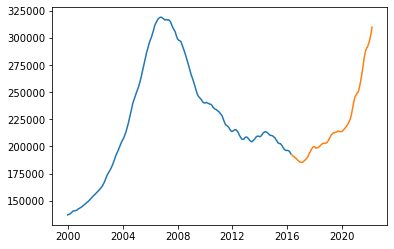

In [32]:
train=atlantic_df[:740]
test=atlantic_df[-247:]
plt.plot(train)
plt.plot(test)

In [33]:
model=auto_arima(train,start_p=0,d=1,start_q=0,
          max_p=5,max_d=5,max_q=5, start_P=0,
          D=1, start_Q=0, max_P=5,max_D=5,
          max_Q=5, m=12, seasonal=True,
          error_action='warn',trace=True,
          supress_warnings=True,stepwise=True,
          random_state=20,n_fits=50)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=12565.230, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=12535.589, Time=0.28 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=12530.725, Time=0.49 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=12565.661, Time=0.09 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=12503.211, Time=0.78 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=12536.002, Time=0.23 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=12503.360, Time=2.55 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=12503.513, Time=2.31 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=12503.552, Time=3.24 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=12518.984, Time=0.93 sec
 ARIMA(0,1,1)(2,1,2)[12]             : AIC=12502.762, Time=2.58 sec
 ARIMA(0,1,1)(3,1,2)[12]             : AIC=12504.764, Time=3.54 sec
 ARIMA(0,1,1)(2,1,3)[12]             : AIC=12504.761, Time=6.09 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=12504.731, Time=4.21 sec
 ARIM

In [37]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  740
Model:             SARIMAX(0, 1, 0)x(2, 1, [1, 2], 12)   Log Likelihood               -6242.615
Date:                                 Sun, 22 May 2022   AIC                          12495.231
Time:                                         13:41:11   BIC                          12518.176
Sample:                                              0   HQIC                         12504.085
                                                 - 740                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.3068      0.079     -3.877      0.000      -0.462      -0.152
ar.S.L24       0.3382      0.066      5.143      0.000       0.209       0.467
ma.S.L12       0.1186      0.079      1.494      0.135      -0.037       0.274
ma.S.L24      -0.5126      0.082     -6.259      0.000      -0.673      -0.352
sigma2      1.636e+06   3.16e-08   5.18e+13      0.000    1.64e+06    1.64e+06
===================================================================================
Ljung-Box (L1) (Q):                   5.01   Jarque-Bera (JB):               480.11
Prob(Q):                              0.03   Prob(JB):                         0.00
Heteroskedasticity (H):               0.13   Skew:                            -0.51
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.2e+29. Standard errors may be unstable.
"""

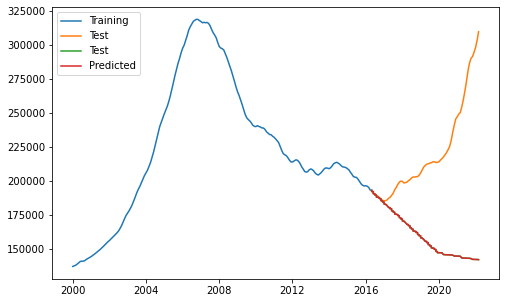

In [38]:
prediction = pd.DataFrame(model.predict(n_periods = 247),index=test.index)
prediction.columns = ['predicted']
plt.figure(figsize=(8,5))
plt.plot(train,label="Training")
plt.plot(test,label="Test")
plt.plot(prediction,label="Predicted")
plt.legend(loc = 'upper left')
plt.savefig('SecondPrection.jpg')
plt.show()

In [39]:
from sklearn.metrics import r2_score
test['predicted'] = prediction
r2_score(test['MedianHousePrice'],test['predicted'])

C:\Users\hluong\AppData\Local\Temp\ipykernel_4996\3149991072.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predicted'] = prediction


-4.554252756698674